In [49]:
import numpy as np                                                             #Must normalize spectra (i.e. find median value across each spectrum, and then divide each spectrum by this value.)
from astropy.io import fits
import matplotlib.pyplot as py
import myAstroMods as mm
import importlib as imp
from astropy.stats import sigma_clip
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from matplotlib.path import Path
imp.reload(mm)
%matplotlib inline

In [2]:
hdu = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/subMasterSPLASH.fits')
hdu2 = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/carbonSPLASHdata/nonCarbonSPLASH.fits')
hdu3 = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/carbonSPLASHdata/marginalCarbonSPLASH.fits')
hdu4 = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/carbonSPLASHdata/weakCarbonSPLASH.fits')
hdu5 = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/carbonSPLASHdata/mediumCarbonSPLASH.fits')
hdu6 = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/carbonSPLASHdata/strongCarbonSPLASH.fits')
hdu7 = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/carbonSPLASHdata/extremeCarbonSPLASH.fits')
wNmIndices = np.load('wNmIndices.npy')
wClusterInd = np.load('Wstar_clusters.npy')
marClusterInd = np.load('Mstar_clusters.npy')
ncClusterInd = np.load('noncarbon_star_clusters.npy')



In [3]:
# Take note! This cell proves that the submaster SPLASH field 'FULLNAME' is unique for every star! good to know...

# for i in range(len(data)):
#     isUnique = data['FULLNAME'][i] == data['FULLNAME']
#     nUnique = isUnique[isUnique == 1]
#     if len(nUnique) != 1:
#         print('ERRRORRRR!')
#         break
# ~np.any(data['FULLNAME'][22091] == clusterData['FULLNAME'])
    

In [4]:
data = hdu[1].data           # All data
ncData = hdu2[1].data        # non-cargon data
marData = hdu3[1].data       # marginal carbon data
wcData = hdu4[1].data        # weak carbon data
mcData = hdu5[1].data        # medium carbon data
scData = hdu6[1].data        # strong carbon data
exData = hdu7[1].data        # extreme carbon data
wNm_data = data[wNmIndices]  # Weak and marginal data




In [5]:
clusterIndices = []
clusterIndices.extend(wClusterInd)
clusterIndices.extend(marClusterInd)
clusterIndices.extend(ncClusterInd)
clusterData = data[clusterIndices]

In [6]:
fluxnorm = []
ivarnorm = []
for i in range(len(wNm_data)):
    [fluxtemp, ivartemp ] = mm.normal(wNm_data['SPEC'][i], wNm_data['IVAR'][i])
    fluxnorm += [fluxtemp]
    ivarnorm += [ivartemp]
fluxnorm = np.array(fluxnorm)
ivarnorm = np.array(ivarnorm)


/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [7]:
wv = wNm_data['LBIN'][0]

In [8]:
# Coaddition of weak AND marginal carbon stars using Katie's weighted ave. method
coaddspec, coaddivar, clipspec, clipivar = mm.sigclip_coadd_arr(wNm_data['LBIN'], fluxnorm, ivarnorm, verbose = True)
clipspec5, clipivar5 = mm.sigclip_coadd_arr(wNm_data['LBIN'], fluxnorm, ivarnorm, sigLim = 5)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:187: RuntimeWarning: invalid value encountered in multiply
  coaddspec = np.nansum(spec*ivar, axis = 0)/coaddivar
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:200: RuntimeWarning: invalid value encountered in less
  subspec.append(np.nansum(s[nsig < sigLim]*iv[nsig < sigLim]))
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:201: RuntimeWarning: invalid value encountered in less
  clipivar.append(np.nansum(iv[nsig < sigLim]))
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:199: RuntimeWarning: invalid value encountered in multiply
  nsig = np.abs((s - coaddspec[j])*np.sqrt(iv))
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:199: RuntimeWarning: invalid value encountered in subtract
  nsig = np.abs((s - coaddspec[j])*np.sqrt(iv))
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:203: RuntimeWarning: invalid value encountered in true_divide
  clipspec

In [9]:
# Coaddition of weak/marginal carbon stars using Elisa's median method
wNmCoadd3med = mm.coadd_med(fluxnorm, ivarnorm, wv)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:261: RuntimeWarning: invalid value encountered in multiply
  sigdiff=abs(fluxnorm-medflux)*np.sqrt(ivarnorm)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:263: RuntimeWarning: invalid value encountered in greater
  clip[sigdiff>siglim]=0
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:265: RuntimeWarning: invalid value encountered in multiply
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:265: RuntimeWarning: invalid value encountered in true_divide
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:266: RuntimeWarning: divide by zero encountered in true_divide
  coadderr=1/np.sqrt(np.nansum(ivarnorm*clip,0))


In [10]:
# Defining smoothing kernels (currently not in unused)
gauss = Gaussian1DKernel(13)
box = Box1DKernel(13)
smoothSpec = convolve(clipspec5, gauss)

(0, 1.6)

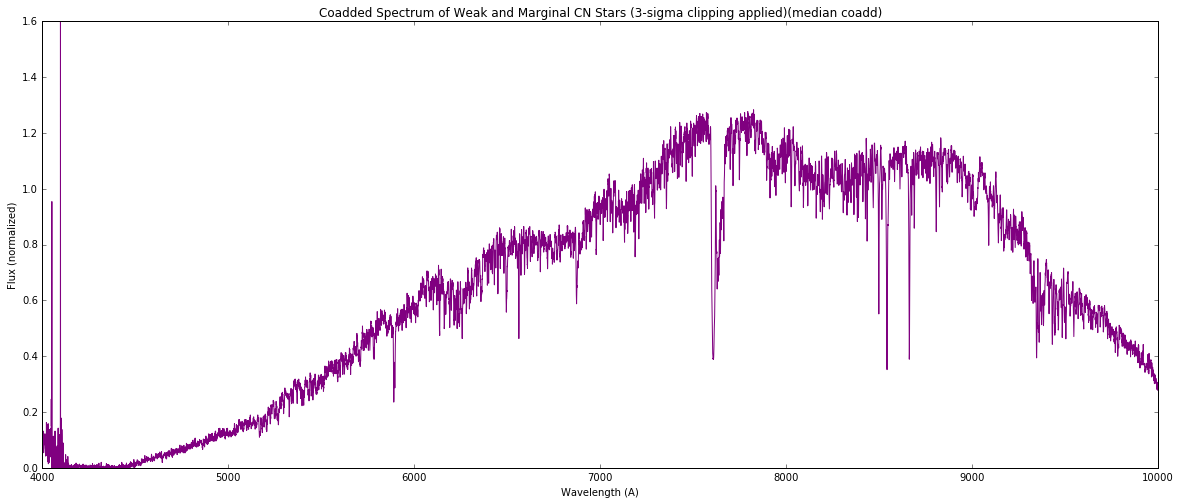

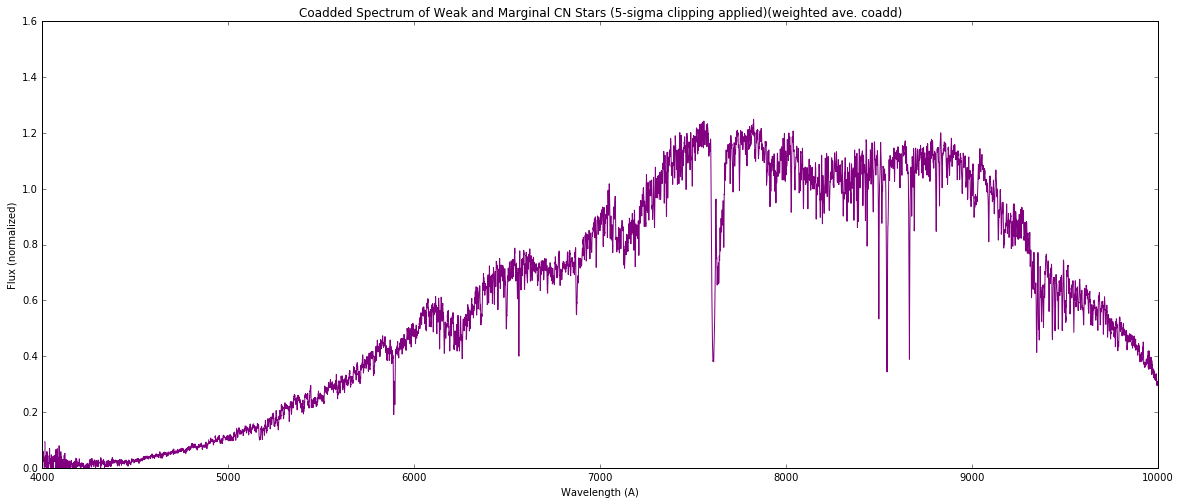

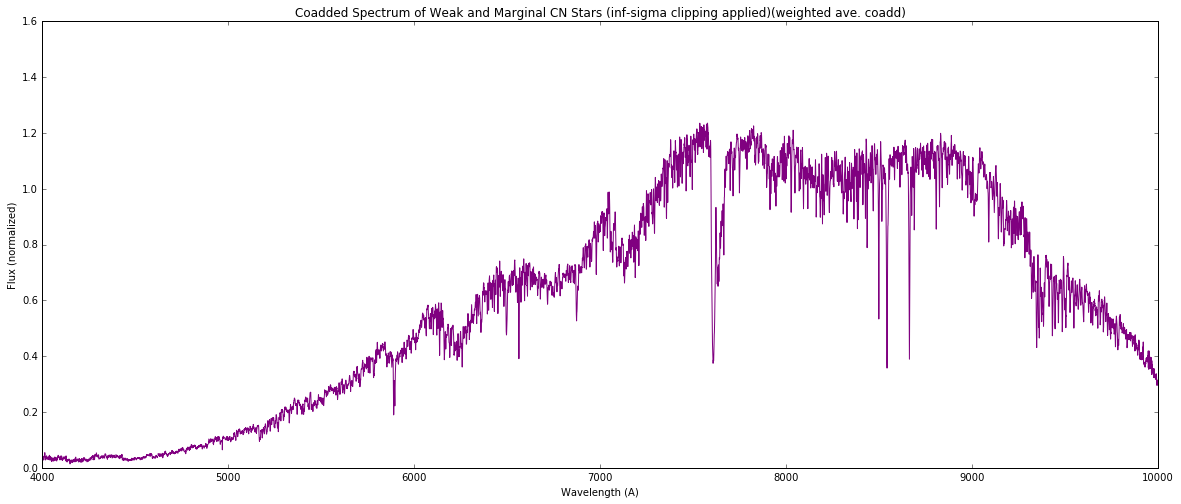

In [11]:
# Visual testing of different amounts/methods of clipspec; surprisingly, simple coaddition with inf-sigma (no clipspec)
# seems to yield the cleanest spectrum.

py.rcParams['figure.figsize'] = 20, 8
py.plot(wv, wNmCoadd3med, 'purple')
py.title('Coadded Spectrum of Weak and Marginal CN Stars (3-sigma clipping applied)(median coadd)')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.6])

py.figure(2)
py.plot(wv, clipspec5, 'purple')
py.title('Coadded Spectrum of Weak and Marginal CN Stars (5-sigma clipping applied)(weighted ave. coadd)')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
# py.xlim([7000, 7100])
py.ylim([0, 1.6])

py.figure(3)
py.plot(wv, coaddspec, 'purple')
py.title('Coadded Spectrum of Weak and Marginal CN Stars (inf-sigma clipping applied)(weighted ave. coadd)')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
# py.xlim([7000, 7100])
py.ylim([0, 1.6])




In [12]:
# This is good! Now do a coaddtion of strong carbon, and non-carbons that fall in same area as weak/marginal carbon stars on CMD, AND n
# non-carbons that fall in same area as strong carbon stars on CMD

In [13]:
weakCy = wNm_data['F160W']
weakCx = wNm_data['F814W'] - wNm_data['F160W']
strongCy = scData['F160W']
strongCx = scData['F814W'] - scData['F160W']

In [14]:
# Lines to determine edges of weak/marginal and strong bins

m = (19 - -52.965)/(2.03045-10)     # Slope of Phil's line, derived from the two points on A^3's plot


# 
x1 = np.arange(1.405, 1.72, .01)
x2 = np.arange(1.925, 2.24, .01)
x3 = np.arange(2.215, 2.374, .005)
x4 = np.arange(2.793, 2.945, .005)
x5 = np.arange(1.09, 1.405, .005)
x6 = np.arange(1.61, 1.925, .005)
x7 = np.arange(2.056, 2.215, .005)
x8 = np.arange(2.63, 2.790, .005)
x9 = np.arange(2.675, 2.99, .01)
x10 = np.arange(3.195, 3.51, .01)
xPhil = np.arange(1, 3, .01)

# Equations of lines determined by using slope of Phil's line, and some guess and check work to find proper y-intercept
y1 = m*x1 + 32
y2 = m*x2 + 36.7
y3 = m*x3 + 37.9
y4 = m*x4 + 43.1
y5 = m*x5 + 32
y6 = m*x6 + 36.7
y7 = m*x7 + 37.9
y8 = m*x8 + 43.1
y9 = m*x9 + 43.45
y10 = m*x10 + 48.15
yPhil = m*xPhil - 2.0345*m + 19     # equation of phil's line
m

-9.029995420067634

In [15]:
(14.8/m + 2.0345 - 19/m)

2.4996165149725558

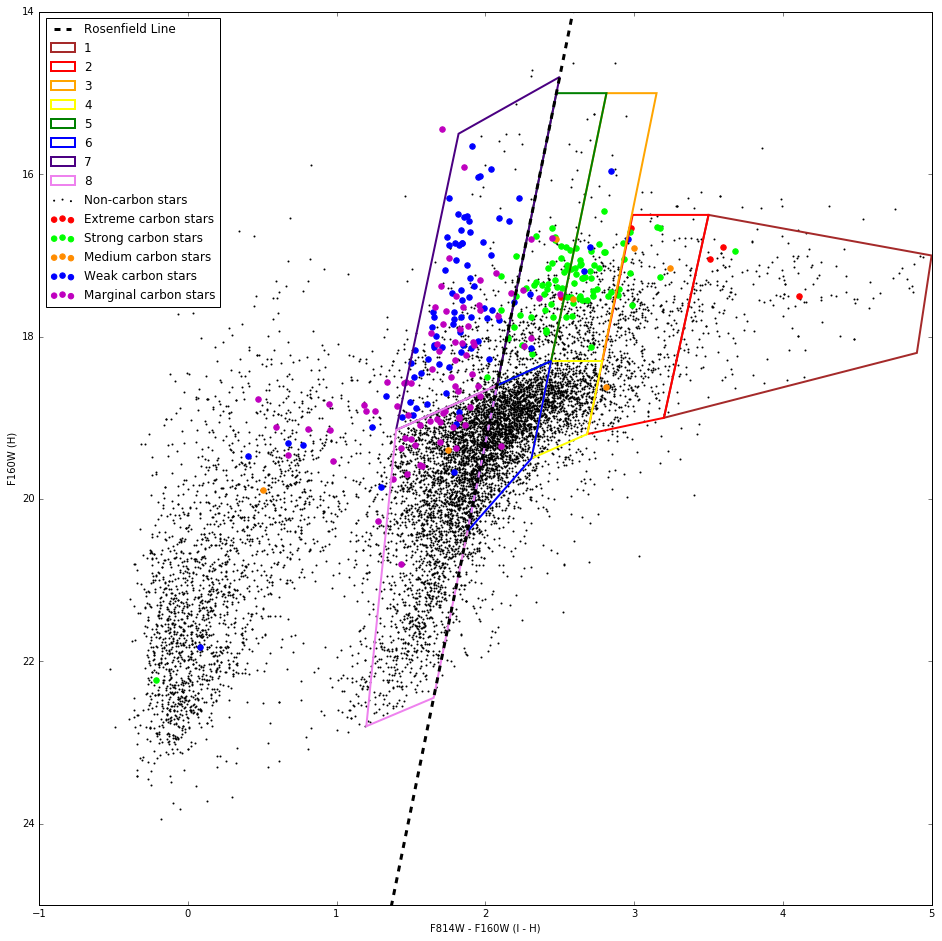

In [57]:
# Plotting all types of stars on H vs. I-H, and defining different bins determined by the slope of phil's line

py.rcParams['figure.figsize'] = 16,16
mm.cmd_plot2(ncData, range(len(ncData)), 1, 'k', label = 'Non-carbon stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot2(exData, range(len(exData)), 30, 'r', label = 'Extreme carbon stars') #EXTREME carbon stars are RED
mm.cmd_plot2(scData, range(len(scData)), 30, 'lime', label = 'Strong carbon stars') #STRONG carbon stars are LIME
mm.cmd_plot2(mcData, range(len(mcData)), 30, 'darkorange', label = 'Medium carbon stars')#MEDIUM carbon stars are DARK ORANGE
mm.cmd_plot2(wcData, range(len(wcData)), 30, 'b', label = 'Weak carbon stars') #WEAK carbon stars are BLUE
mm.cmd_plot2(marData, range(len(marData)), 30, 'm', label = 'Marginal carbon stars') #MARGINAL carbon stars are MAGENTA 

py.plot(xPhil, yPhil, color = 'k', linewidth = 3, linestyle = '--', label = 'Rosenfield Line')

bin1 = py.Polygon([[3.2, 19.], [3.50, 16.5], [4.999, 17], [4.9, 18.2]], color = 'brown', fill = False, label ='1', linewidth = 2)
bin1path = Path([[3.2, 19.], [3.50, 16.5], [4.999, 17], [4.9, 18.2]])
py.gca().add_patch(bin1)

bin2 = py.Polygon([[2.99, 16.5], [2.685, 19.2], [3.2, 19.], [3.50, 16.5]], color = 'red', fill = False, label ='2', linewidth = 2)
bin2path = Path([[2.99, 16.5], [2.685, 19.2], [3.2, 19.], [3.50, 16.5]])
py.gca().add_patch(bin2)
# mask = bin5.contains_point([1,0])

bin3 = py.Polygon([[2.814, 15], [3.1506, 15], [2.785, 18.3], [2.442, 18.3]], color = 'orange', fill = False, label ='3', linewidth = 2)
bin3path = Path([[2.814, 15], [3.1506, 15], [2.785, 18.3], [2.442, 18.3]])
py.gca().add_patch(bin3)

bin4 = py.Polygon([[2.442, 18.3], [2.785, 18.3], [2.685, 19.2], [2.31, 19.5]], color = 'yellow', fill = False, label ='4', linewidth = 2)
bin4path = Path([[2.442, 18.3], [2.785, 18.3], [2.685, 19.2], [2.31, 19.5]])
py.gca().add_patch(bin4)

bin5 = py.Polygon([[2.477468, 15], [2.814, 15], [2.442, 18.3], [2.079, 18.6]], color = 'green', fill = False, label ='5', linewidth = 2)
bin5path = Path([[2.477468, 15], [2.814, 15], [2.442, 18.3], [2.079, 18.6]])
py.gca().add_patch(bin5)

bin6 = py.Polygon([[2.079, 18.6], [2.442, 18.3], [2.31, 19.5], [1.8795, 20.4]], color = 'blue', fill = False, label ='6', linewidth = 2)
bin6path = Path([[2.079, 18.6], [2.442, 18.3], [2.31, 19.5], [1.8795, 20.4]])
py.gca().add_patch(bin6)

bin7 = py.Polygon([[1.4,19.15],[2.079, 18.6],[2.4996,14.8],[1.82,15.5]], color = 'indigo', fill = False, label = '7', linewidth = 2)
bin7path = Path([[1.4,19.15],[2.079, 18.6],[2.4996,14.8],[1.82,15.5]])
py.gca().add_patch(bin7)

bin8 = py.Polygon([[1.4,19.15],[2.079, 18.6],[1.6524,22.45],[1.2,22.8]], color = 'violet', fill = False, label = '8', linewidth = 2)
bin8path = Path([[1.4,19.15],[2.079, 18.6],[1.6524,22.45],[1.2,22.8]])
py.gca().add_patch(bin8)





# refPoint= py.scatter(4.9, 18., s=100, color = 'magenta')
# refPoint2= py.scatter(2.8455, 17.75, s=100, color = 'orange')


py.xlim(-1, 5)
py.ylim(25, 14)

py.xlabel('F814W - F160W (I - H)')
py.ylabel('F160W (H)')
py.legend(bbox_to_anchor=(.21, 1))

In [17]:
# Extract indices for non-carbon stars within each bin. This cell takes quite a while to run..NOTE: these indices are for non-carbon .fits file!

bin1Indices = [i for i in range(len(ncData)) if bin1path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin2Indices = [i for i in range(len(ncData)) if bin2path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin3Indices = [i for i in range(len(ncData)) if bin3path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin4Indices = [i for i in range(len(ncData)) if bin4path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin5Indices = [i for i in range(len(ncData)) if bin5path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin6Indices = [i for i in range(len(ncData)) if bin6path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin7Indices = [i for i in range(len(ncData)) if bin7path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin8Indices = [i for i in range(len(ncData)) if bin8path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]



In [18]:
# Extract indices for C stars within bins that contain majority of C stars. NOTE: these indices are for the 'strong carbon' .fits file!

bin3Cindices = [i for i in range(len(scData)) if bin3path.contains_point([scData['F814W'][i] - scData['F160W'][i], scData['F160W'][i]])
               and ~np.any(scData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin5Cindices = [i for i in range(len(scData)) if bin5path.contains_point([scData['F814W'][i] - scData['F160W'][i], scData['F160W'][i]])
               and ~np.any(scData['FULLNAME'][i] == clusterData['FULLNAME'])]

In [19]:
# Extract indices for weak CN stars within bins that contain the majority of weak CN stars. NOTE: these indices are for the wNm_data object!

bin7weakCNind = [i for i in range(len(wNm_data)) if bin7path.contains_point([wNm_data['F814W'][i] - wNm_data['F160W'][i], wNm_data['F160W'][i]])
                and ~np.any(wNm_data['FULLNAME'][i] == clusterData['FULLNAME'])]
bin8weakCNind = [i for i in range(len(wNm_data)) if bin8path.contains_point([wNm_data['F814W'][i] - wNm_data['F160W'][i], wNm_data['F160W'][i]])
                and ~np.any(wNm_data['FULLNAME'][i] == clusterData['FULLNAME'])]

In [20]:
bin1data = ncData[bin1Indices]
bin2data = ncData[bin2Indices]
bin3data = ncData[bin3Indices]
bin4data = ncData[bin4Indices]
bin5data = ncData[bin5Indices]
bin6data = ncData[bin6Indices]
bin7data = ncData[bin7Indices]
bin8data = ncData[bin8Indices]

bin3Cdata = scData[bin3Cindices]
bin5Cdata = scData[bin5Cindices]

bin7weakCNdata = wNm_data[bin7weakCNind]
bin8weakCNdata = wNm_data[bin8weakCNind]



In [21]:
bin1X = bin1data['F814W'] - bin1data['F160W']
bin1Y = bin1data['F160W']

bin2X = bin2data['F814W'] - bin2data['F160W']
bin2Y = bin2data['F160W']

bin3X = bin3data['F814W'] - bin3data['F160W']
bin3Y = bin3data['F160W']

bin4X = bin4data['F814W'] - bin4data['F160W']
bin4Y = bin4data['F160W']

bin8X = bin8data['F814W'] - bin8data['F160W']
bin8Y = bin8data['F160W']

bin7X = bin7data['F814W'] - bin7data['F160W']
bin7Y = bin7data['F160W']


bin3CX = bin3Cdata['F814W'] - bin3Cdata['F160W']
bin3CY = bin3Cdata['F160W']

bin5CX = bin5Cdata['F814W'] - bin5Cdata['F160W']
bin5CY = bin5Cdata['F160W']






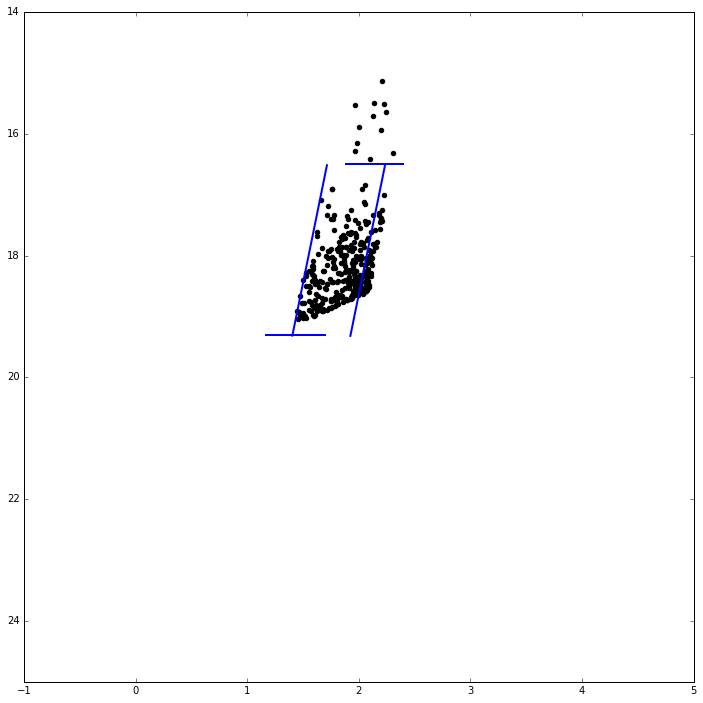

In [22]:
# This block can be used to visually test to see if non-carbon populations fall within desired bins..i.e. ERROR check

py.rcParams['figure.figsize'] = 12, 12
py.xlim([-1, 5])
py.ylim([25, 14])
# py.scatter(bin3data['F814W'] - bin3data['F160W'], bin3data['F160W'], color = 'k')

# Weak/marginal bin
scat1 = py.scatter(bin7X, bin7Y, color = 'k', label = 'Non-carbon stars')
py.plot(x1, y1, 'blue', linewidth = 2)
py.plot(x2, y2, 'blue', linewidth = 2)
py.plot([1.89, 2.4], [16.5, 16.5], 'blue', linewidth = 2)
py.plot([1.165, 1.7], [19.3, 19.3], 'blue', linewidth = 2)

# # Strong Carbon bin
# py.scatter(strongZoneX, strongZoneY, color = 'k')
# py.plot(x3, y3, 'green', linewidth = 2)
# py.plot(x4, y4, 'green', linewidth = 2)
# py.plot([2.45, 3.080], [16.7, 16.7], 'green', linewidth = 2)
# py.plot([2.16, 2.8], [17.8, 17.8], 'green', linewidth = 2)

# py.scatter(bin3X, bin3Y, color = 'k')
# py.plot(x3, y3, 'green', linewidth = 2)
# py.plot(x4, y4, 'green', linewidth = 2)
# py.plot([2.45, 3.080], [16.7, 16.7], 'green', linewidth = 2)
# py.plot([2.16, 2.8], [17.8, 17.8], 'green', linewidth = 2)

# py.xlabel('F814W - F160W (I - H)')
# py.ylabel('F160W (H)')
# py.legend(handles=[scat1])



In [23]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #1

fluxnorm1 = []
ivarnorm1 = []
for i in range(len(bin1data)):
    [fluxtemp, ivartemp ] = mm.normal(bin1data['SPEC'][i], bin1data['IVAR'][i])
    fluxnorm1 += [fluxtemp]
    ivarnorm1 += [ivartemp]
fluxnorm1 = np.array(fluxnorm1)
ivarnorm1 = np.array(ivarnorm1)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [24]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #2

fluxnorm2 = []
ivarnorm2 = []
for i in range(len(bin2data)):
    [fluxtemp, ivartemp ] = mm.normal(bin2data['SPEC'][i], bin2data['IVAR'][i])
    fluxnorm2 += [fluxtemp]
    ivarnorm2 += [ivartemp]
fluxnorm2 = np.array(fluxnorm2)
ivarnorm2 = np.array(ivarnorm2)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [25]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #3

fluxnorm3 = []
ivarnorm3 = []
for i in range(len(bin3data)):
    [fluxtemp, ivartemp ] = mm.normal(bin3data['SPEC'][i], bin3data['IVAR'][i])
    fluxnorm3 += [fluxtemp]
    ivarnorm3 += [ivartemp]
fluxnorm3 = np.array(fluxnorm3)
ivarnorm3 = np.array(ivarnorm3)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [26]:
# Normalizing spectra and ivar of carbon stars residing in bin #3

fluxnorm3C = []
ivarnorm3C = []
for i in range(len(bin3Cdata)):
    [fluxtemp, ivartemp ] = mm.normal(bin3Cdata['SPEC'][i], bin3Cdata['IVAR'][i])
    fluxnorm3C += [fluxtemp]
    ivarnorm3C+= [ivartemp]
fluxnorm3C = np.array(fluxnorm3C)
ivarnorm3C = np.array(ivarnorm3C)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [27]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #4

fluxnorm4 = []
ivarnorm4 = []
for i in range(len(bin4data)):
    [fluxtemp, ivartemp ] = mm.normal(bin4data['SPEC'][i], bin4data['IVAR'][i])
    fluxnorm4 += [fluxtemp]
    ivarnorm4 += [ivartemp]
fluxnorm4 = np.array(fluxnorm4)
ivarnorm4 = np.array(ivarnorm4)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [28]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #5

fluxnorm5 = []
ivarnorm5 = []
for i in range(len(bin5data)):
    [fluxtemp, ivartemp ] = mm.normal(bin5data['SPEC'][i], bin5data['IVAR'][i])
    fluxnorm5 += [fluxtemp]
    ivarnorm5 += [ivartemp]
fluxnorm5 = np.array(fluxnorm5)
ivarnorm5 = np.array(ivarnorm5)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [29]:
# Normalizing spectra and ivar of carbon stars residing in bin #5

fluxnorm5C = []
ivarnorm5C = []
for i in range(len(bin5Cdata)):
    [fluxtemp, ivartemp ] = mm.normal(bin5Cdata['SPEC'][i], bin5Cdata['IVAR'][i])
    fluxnorm5C += [fluxtemp]
    ivarnorm5C+= [ivartemp]
fluxnorm5C = np.array(fluxnorm5C)
ivarnorm5C = np.array(ivarnorm5C)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [30]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #6

fluxnorm6 = []
ivarnorm6 = []
for i in range(len(bin6data)):
    [fluxtemp, ivartemp ] = mm.normal(bin6data['SPEC'][i], bin6data['IVAR'][i])
    fluxnorm6 += [fluxtemp]
    ivarnorm6 += [ivartemp]
fluxnorm6 = np.array(fluxnorm6)
ivarnorm6 = np.array(ivarnorm6)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [31]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #7

fluxnorm7 = []
ivarnorm7 = []
for i in range(len(bin7data)):
    [fluxtemp, ivartemp ] = mm.normal(bin7data['SPEC'][i], bin7data['IVAR'][i])
    fluxnorm7 += [fluxtemp]
    ivarnorm7 += [ivartemp]
fluxnorm7 = np.array(fluxnorm7)
ivarnorm7 = np.array(ivarnorm7)

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [32]:
# Normalizing spectra and ivar of weak CN stars residing in bin #7

fluxnorm7weakCN = []
ivarnorm7weakCN = []
for i in range(len(bin7weakCNdata)):
    [fluxtemp, ivartemp ] = mm.normal(bin7weakCNdata['SPEC'][i], bin7weakCNdata['IVAR'][i])
    fluxnorm7weakCN += [fluxtemp]
    ivarnorm7weakCN += [ivartemp]
fluxnorm7weakCN = np.array(fluxnorm7weakCN)
ivarnorm7weakCN = np.array(ivarnorm7weakCN)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [33]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #8

fluxnorm8 = []
ivarnorm8 = []
for i in range(len(bin8data)):
    [fluxtemp, ivartemp ] = mm.normal(bin8data['SPEC'][i], bin8data['IVAR'][i])
    fluxnorm8 += [fluxtemp]
    ivarnorm8 += [ivartemp]
fluxnorm8 = np.array(fluxnorm8)
ivarnorm8 = np.array(ivarnorm8)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [34]:
# Normalizing spectra and ivar of weak CN stars residing in bin #8

fluxnorm8weakCN = []
ivarnorm8weakCN = []
for i in range(len(bin8weakCNdata)):
    [fluxtemp, ivartemp ] = mm.normal(bin8weakCNdata['SPEC'][i], bin8weakCNdata['IVAR'][i])
    fluxnorm8weakCN += [fluxtemp]
    ivarnorm8weakCN += [ivartemp]
fluxnorm8weakCN = np.array(fluxnorm8weakCN)
ivarnorm8weakCN = np.array(ivarnorm8weakCN)

In [35]:
# Coadding spectra of non-carbon populations within indicated bin using 3-sigma clipping and median coadd method

bin1Coadd = mm.coadd_med(fluxnorm1, ivarnorm1, wv)
bin2Coadd = mm.coadd_med(fluxnorm2, ivarnorm2, wv)
bin3Coadd = mm.coadd_med(fluxnorm3, ivarnorm3, wv)
bin4Coadd = mm.coadd_med(fluxnorm4, ivarnorm4, wv)
bin5Coadd = mm.coadd_med(fluxnorm5, ivarnorm5, wv)
bin6Coadd = mm.coadd_med(fluxnorm6, ivarnorm6, wv)
bin7Coadd = mm.coadd_med(fluxnorm7, ivarnorm7, wv)
bin8Coadd = mm.coadd_med(fluxnorm8, ivarnorm8, wv)


//anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:739: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:261: RuntimeWarning: invalid value encountered in multiply
  sigdiff=abs(fluxnorm-medflux)*np.sqrt(ivarnorm)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:263: RuntimeWarning: invalid value encountered in greater
  clip[sigdiff>siglim]=0
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:265: RuntimeWarning: invalid value encountered in multiply
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:265: RuntimeWarning: invalid value encountered in true_divide
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:266: RuntimeWarning: divide by zero encountered in tr

In [36]:
# Coadding spectra of carbon and weak CN populations within indicated bin using 3-sigma clipping and median coadd method

bin3C_Coadd = mm.coadd_med(fluxnorm3C, ivarnorm3C, wv)
bin5C_Coadd = mm.coadd_med(fluxnorm5C, ivarnorm5C, wv)

bin7wCNcoadd = mm.coadd_med(fluxnorm7weakCN, ivarnorm7weakCN, wv)
bin8wCNcoadd = mm.coadd_med(fluxnorm8weakCN, ivarnorm8weakCN, wv)


//anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:739: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:261: RuntimeWarning: invalid value encountered in multiply
  sigdiff=abs(fluxnorm-medflux)*np.sqrt(ivarnorm)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:263: RuntimeWarning: invalid value encountered in greater
  clip[sigdiff>siglim]=0
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:265: RuntimeWarning: invalid value encountered in multiply
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:265: RuntimeWarning: invalid value encountered in true_divide
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:266: RuntimeWarning: divide by zero encountered in tr

(0, 1.5)

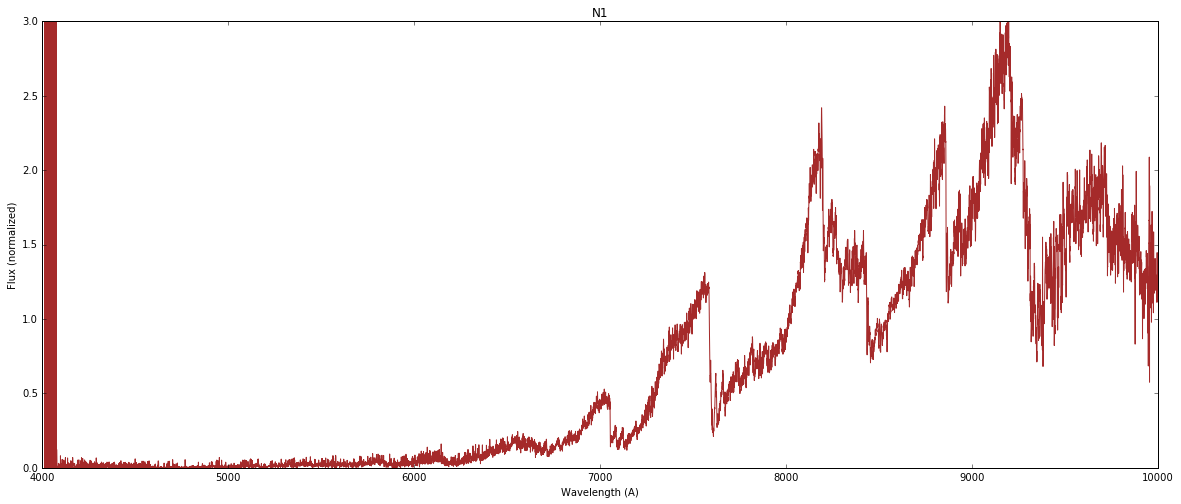

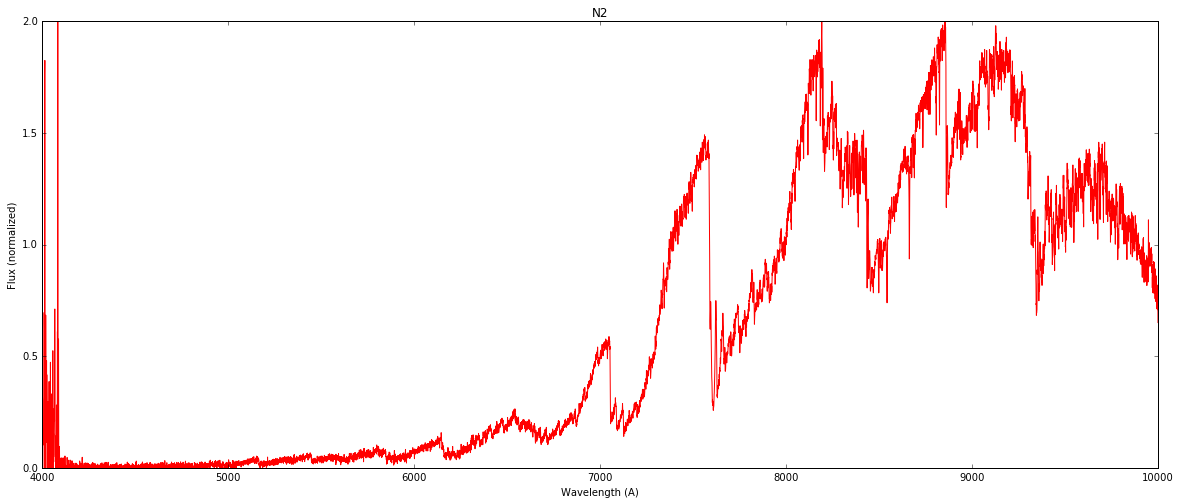

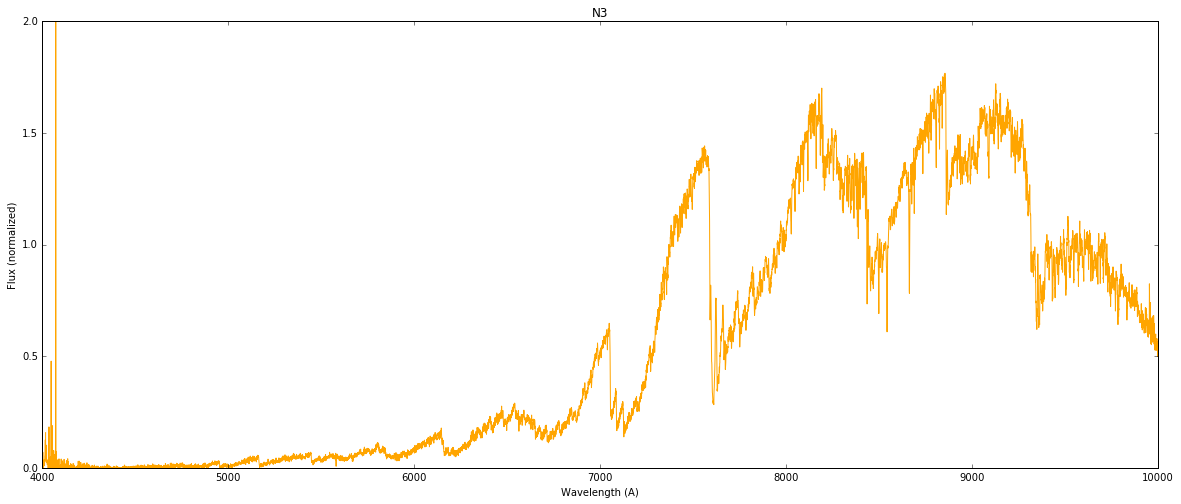

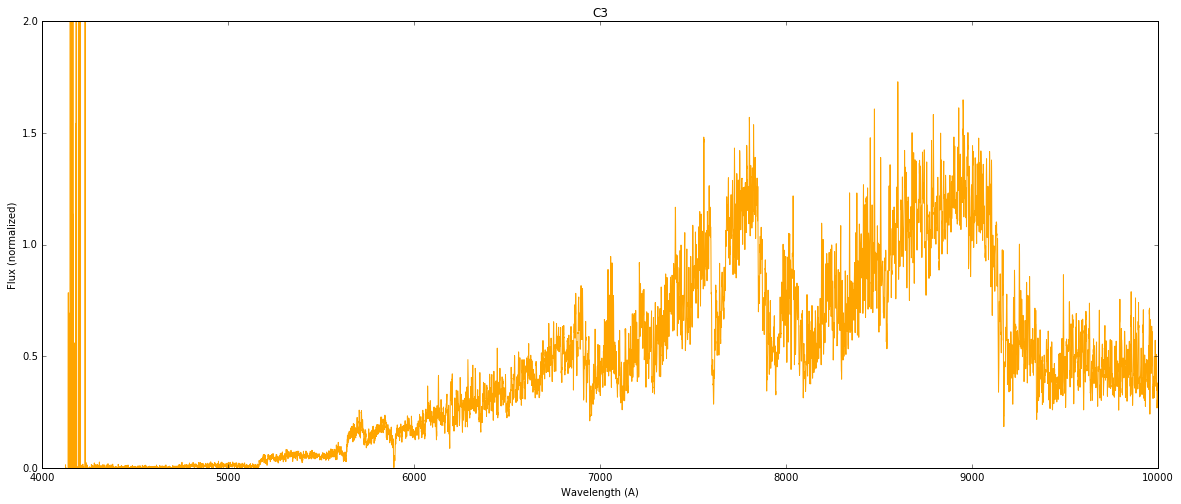

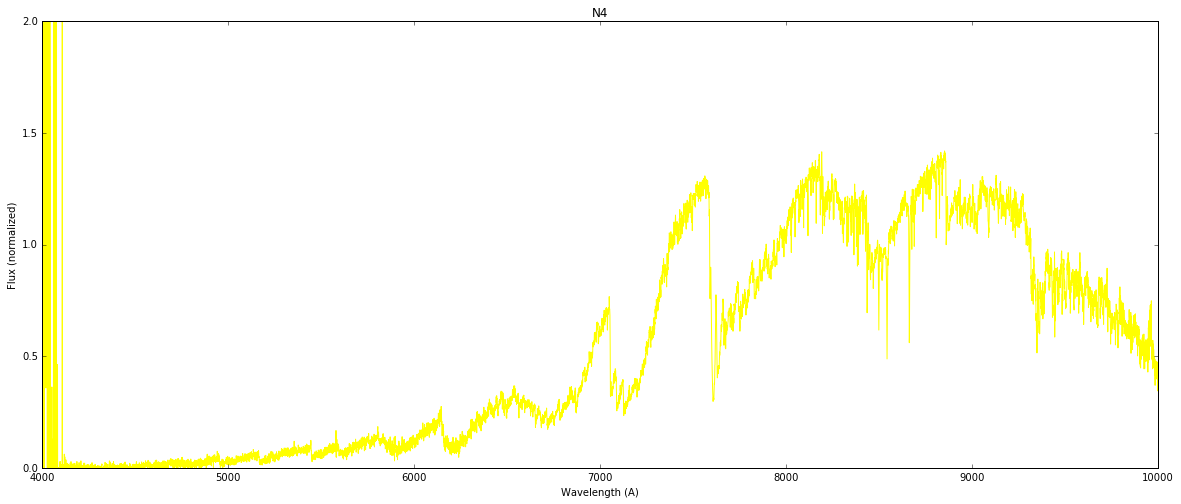

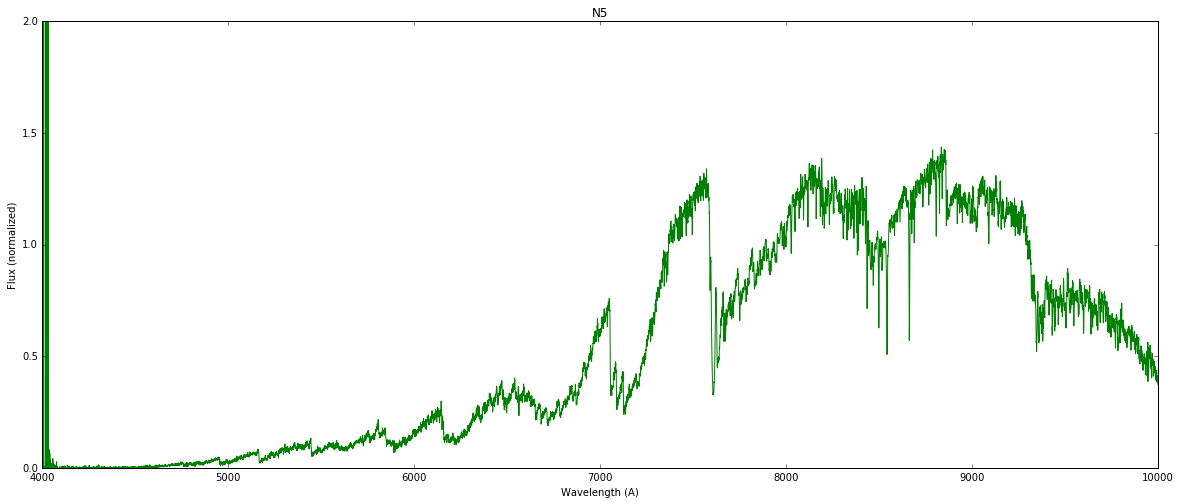

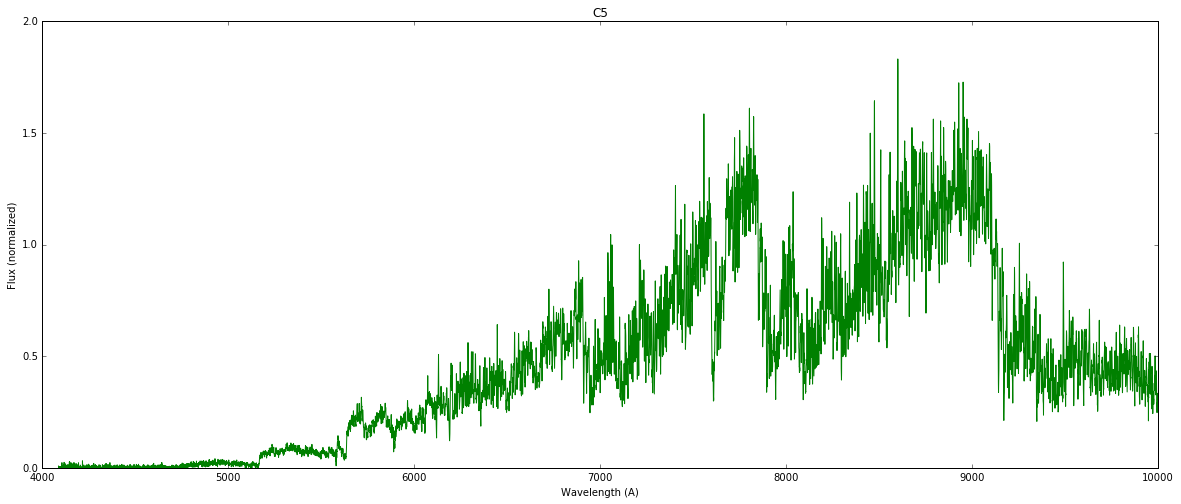

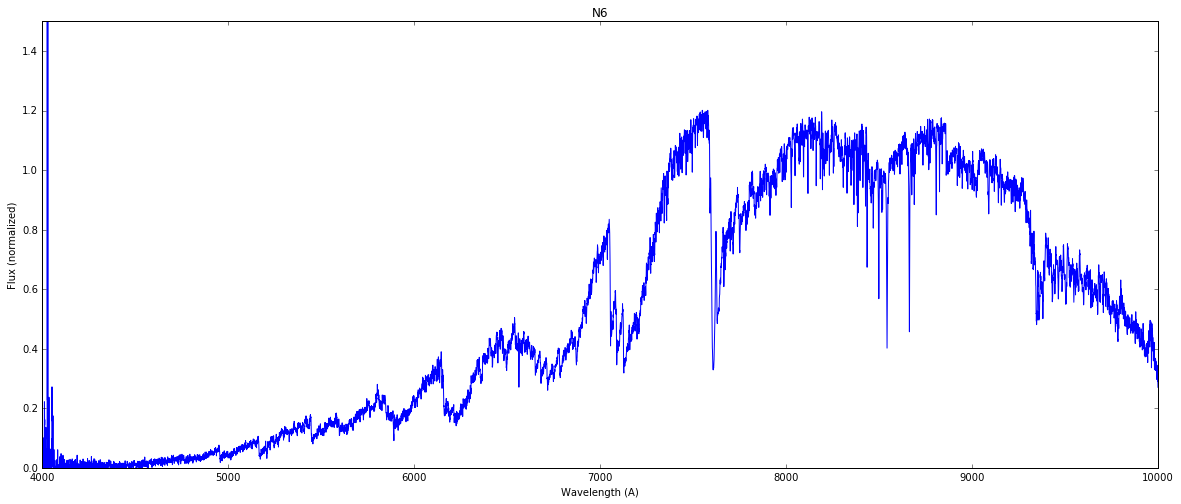

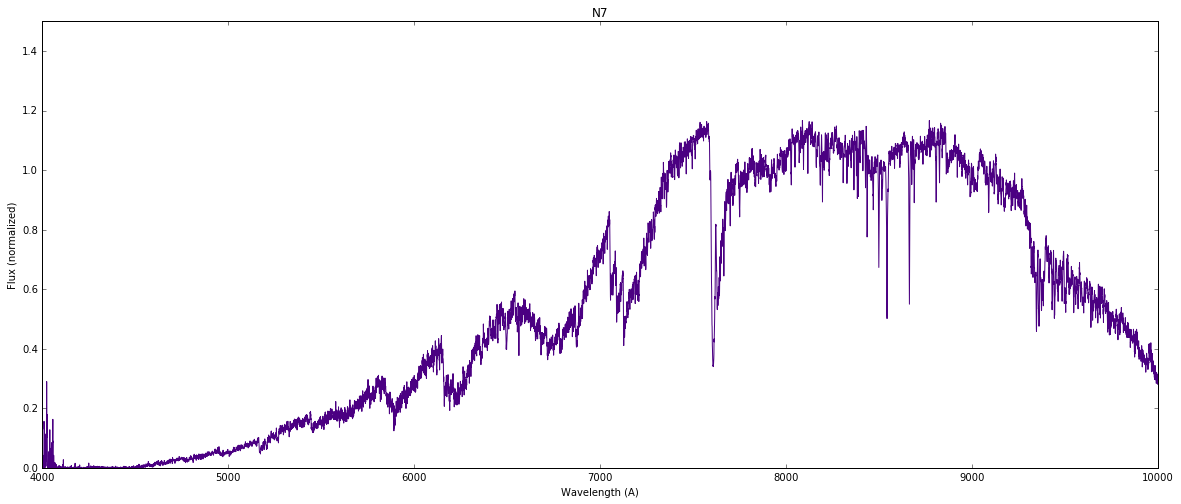

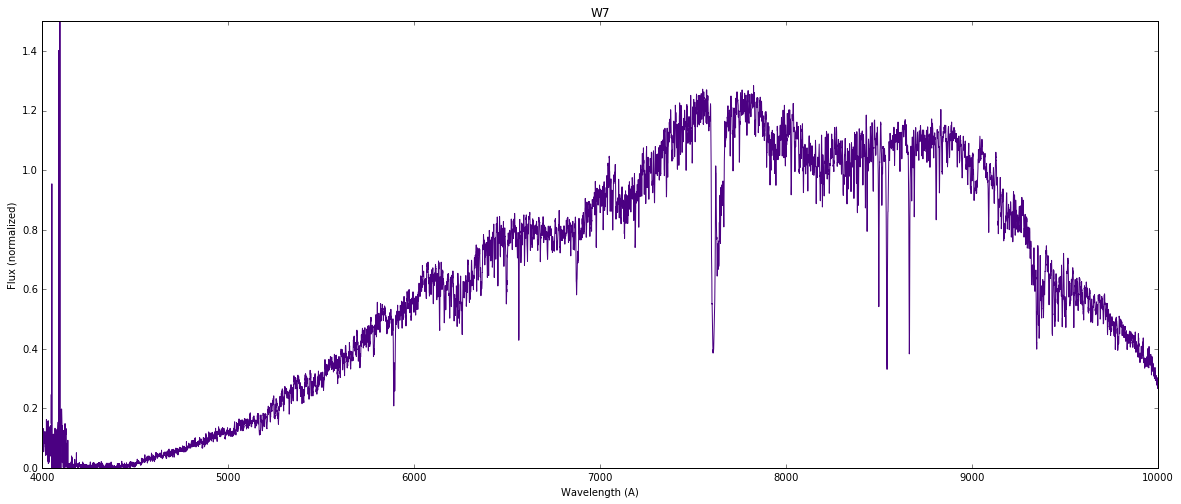

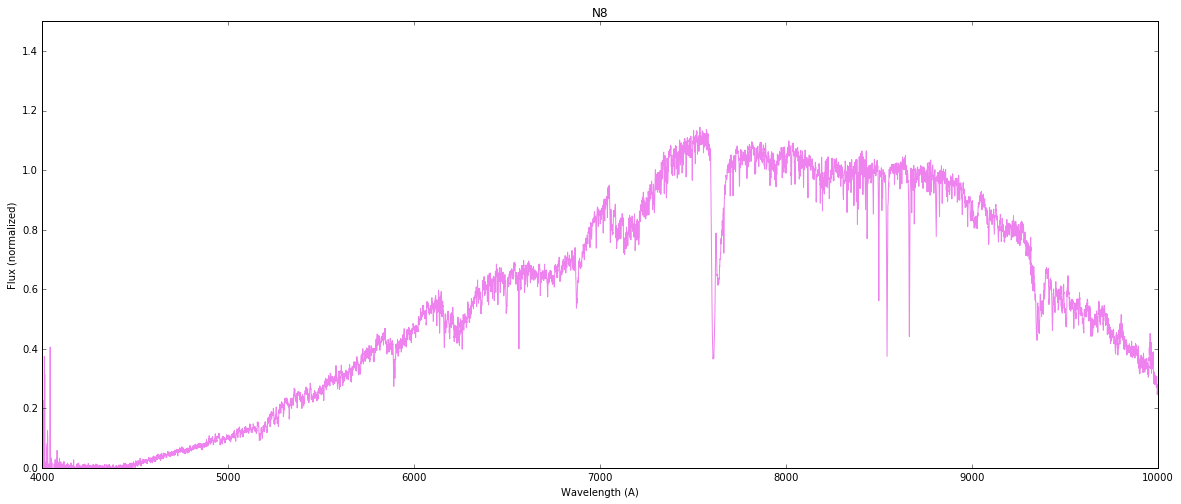

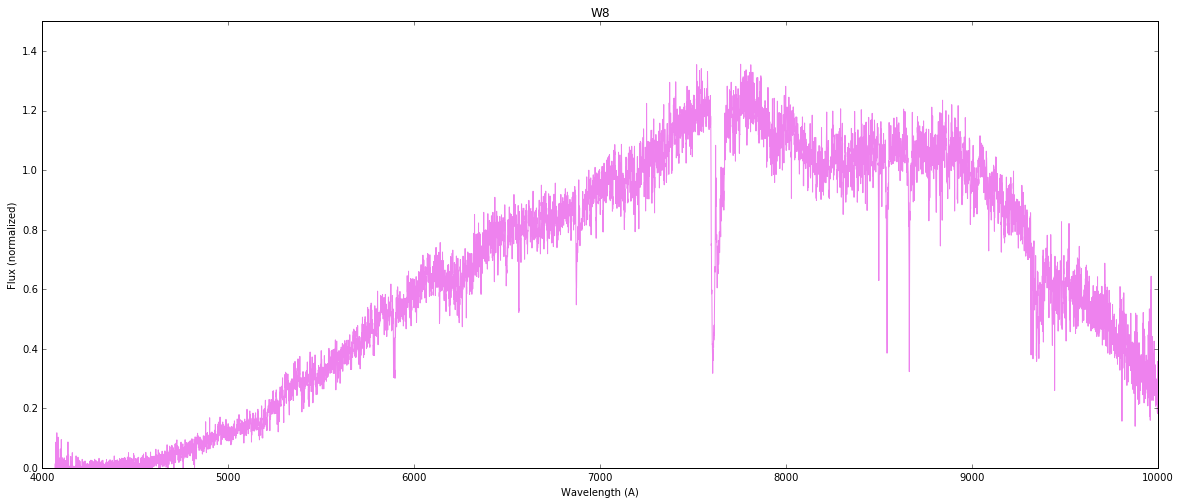

In [59]:
py.rcParams['figure.figsize'] = 20, 8

# Coadd of non-carbon stars in bin #1
py.figure(1)
py.plot(wv, bin1Coadd, 'brown')
py.title('N1')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 3])

# Coadd of non-carbon stars in bin #2
py.figure(2)
py.plot(wv, bin2Coadd, 'red')
py.title('N2')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of non-carbon stars in bin #3
py.figure(3)
py.plot(wv, bin3Coadd, 'orange')
py.title('N3')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of carbon stars in bin #3
py.figure(4)
py.plot(wv, bin3C_Coadd, 'orange')
py.title('C3')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of non-carbon stars in bin #4
py.figure(5)
py.plot(wv, bin4Coadd, 'yellow')
py.title('N4')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of non-carbon stars in bin #5
py.figure(6)
py.plot(wv, bin5Coadd, 'green')
py.title('N5')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of carbon stars in bin #5
py.figure(7)
py.plot(wv, bin5C_Coadd, 'green')
py.title('C5')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of non-carbon stars in bin #6
py.figure(8)
py.plot(wv, bin6Coadd, 'blue')
py.title('N6')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of non-carbon stars in bin #7
py.figure(9)
py.plot(wv, bin7Coadd, 'indigo')
py.title('N7')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of weak CN stars in bin #7
py.figure(10)
py.plot(wv, bin7wCNcoadd, 'indigo')
py.title('W7')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of non-carbon stars in bin #8
py.figure(11)
py.plot(wv, bin8Coadd, 'violet')
py.title('N8')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of weak CN stars in bin #8
py.figure(12)
py.plot(wv, bin8wCNcoadd, 'violet')
py.title('W8')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

(32, 15)

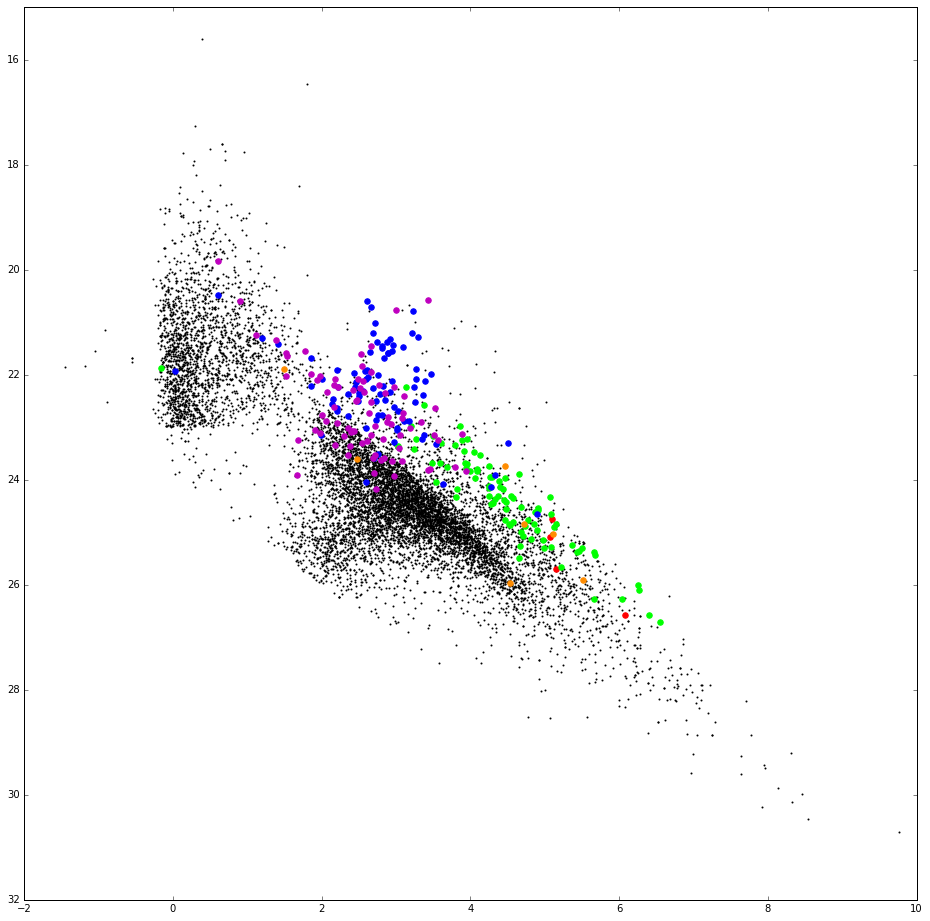

In [53]:
# Experiment based off of HeB paper. Plot CMD of V vs. V - I

py.rcParams['figure.figsize'] = 16,16
mm.cmd_plot3(ncData, range(len(ncData)), 1, 'k', label = 'Non-carbon stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot3(exData, range(len(exData)), 30, 'r', label = 'Extreme carbon stars') #EXTREME carbon stars are RED
mm.cmd_plot3(scData, range(len(scData)), 30, 'lime', label = 'Strong carbon stars') #STRONG carbon stars are LIME
mm.cmd_plot3(mcData, range(len(mcData)), 30, 'darkorange', label = 'Medium carbon stars')#MEDIUM carbon stars are DARK ORANGE
mm.cmd_plot3(wcData, range(len(wcData)), 30, 'b', label = 'Weak carbon stars') #WEAK carbon stars are BLUE
mm.cmd_plot3(marData, range(len(marData)), 30, 'm', label = 'Marginal carbon stars') #MARGINAL carbon stars are MAGENTA 
py.xlim([-2, 10])
py.ylim([32, 15])

In [48]:
1/np.cos(37*np.pi/180)

1.2521356581562257